# Self-Similarity

## To import modules

In [3]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel, AutoConfig
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import os

## To load data and add time attributes

In [13]:
data = pd.read_csv('data/dataset.csv')
data = data[['book', 'chapter']]
# read output.txt file, and load it into the data dataframe, as a new column called 'segmented'
if os.path.exists('data/word_segmentation.txt'):
    with open('data/word_segmentation.txt', 'r') as f:
        lines = f.readlines()
    data['segmented'] = lines

In [14]:
data.head()

,book,chapter,segmented
0,analects,學而,子 曰 学 而 时 习 之 不 亦 说 乎 有 朋 自 远 方 来 不 亦 乐 乎 人 不 ...
1,analects,為政,子 曰 为 政 以 德 譬 如 北 辰 居 其 所 而 众 星 共 之 子 曰 诗 三百 一...
2,analects,八佾,孔子 谓 季 氏 八 佾 舞 于 庭 是 可 忍 也 孰 不 可 忍 也 三 家 者 以 雍...
3,analects,里仁,子 曰 里 仁 为 美 择 不 处 仁 焉 得 知 子 曰 不 仁 者 不 可 以 久 处 ...
4,analects,公冶長,子 谓 公冶 长 可 妻 也 虽 在 缧 绁 之 中 非 其 罪 也 以 其 子 妻 之 子...


In [15]:
list_bookname = list(data["book"].unique())
list_book_time = [
    ['analects',-480, -350],
    ['mengzi',  -340, -250],
    ['liji',    -475, -221],
    ['xunzi',   -475, -221],
    ['xiao-jing',-475, -221],
    ['shuo-yuan',-206, 9],
    ['chun-qiu-fan-lu',-206, 9],
    ['han-shi-wai-zhuan',-180, -120],
    ['da-dai-li-ji',100, 200],
    ['bai-hu-tong',79, 92],
    ['xin-shu', -206, 9],
    ['xin-xu',-206, 9],
    ['yangzi-fayan',-33, 18],
    ['zhong-lun',25, 220],
    ['kongzi-jiayu',-206, 220],
    ['qian-fu-lun',102, 167],
    ['lunheng', 80, 80],
    ['taixuanjing',-33, 18],
    ['fengsutongyi',190, 200],
    ['kongcongzi',25, 265],
    ['shenjian',196, 220],
    ['zhong-jing',100,166],
    ['su-shu',-250,-186],
    ['xinyu',-196, -196],
    ['duduan',167, 258],
    ['caizhong-langji', 152, 192]
]
def map_year(year):
    return int(year/2 + 2000)
def set_time_attributes(df):
    """
    This function sets the time attributes "Start", "End", and "era" for each book in the input dataframe.

    Parameters:
    df (pandas.DataFrame): The input dataframe. It should contain a column named "book".

    Returns:
    pandas.DataFrame: The input dataframe with three new columns: "Start", "End", and "era". Each row represents a book.
    - "Start" is the start year of the book.
    - "End" is the end year of the book.
    - "era" is the average of the start year and the end year.
    """
    df["Start"] = None  # Initialize the "Start" column
    df["End"] = None  # Initialize the "End" column
    df["average_year"] = None
    df['mapped_year'] = None
    num = list_bookname.index(df.iloc[0]["book"])  # Get the index of the first book in the list of book names
    for i in range(df.shape[0]):  # For each row in the dataframe
        num = list_bookname.index(df.iloc[i]["book"])  # Get the index of the book in the list of book names
        df.loc[i, 'Start'] = list_book_time[num][1]  # Set the "Start" attribute
        df.loc[i, 'End'] = list_book_time[num][2]  # Set the "End" attribute
    for i in range(df.shape[0]):  # For each row in the dataframe
        df.loc[i, 'average_year'] = int((df.loc[i, 'Start']+df.loc[i, 'End'])/2)
    df['mapped_year'] = df['average_year'].apply(map_year)
    return df  # Return the dataframe with the new attributes

In [16]:
data = set_time_attributes(data)
data = data[["book", "chapter", "segmented", "average_year", "mapped_year"]]
data['contain_ren'] = data['segmented'].apply(lambda x: 1 if '仁' in x else 0)

In [17]:
data.head()

,book,chapter,segmented,average_year,mapped_year,contain_ren
0,analects,學而,子 曰 学 而 时 习 之 不 亦 说 乎 有 朋 自 远 方 来 不 亦 乐 乎 人 不 ...,-415,1792,1
1,analects,為政,子 曰 为 政 以 德 譬 如 北 辰 居 其 所 而 众 星 共 之 子 曰 诗 三百 一...,-415,1792,0
2,analects,八佾,孔子 谓 季 氏 八 佾 舞 于 庭 是 可 忍 也 孰 不 可 忍 也 三 家 者 以 雍...,-415,1792,1
3,analects,里仁,子 曰 里 仁 为 美 择 不 处 仁 焉 得 知 子 曰 不 仁 者 不 可 以 久 处 ...,-415,1792,1
4,analects,公冶長,子 谓 公冶 长 可 妻 也 虽 在 缧 绁 之 中 非 其 罪 也 以 其 子 妻 之 子...,-415,1792,1


## 

## To load Models

In [18]:
# Load sentence segmentation model
tokenizer_seg = AutoTokenizer.from_pretrained("KoichiYasuoka/roberta-classical-chinese-base-sentence-segmentation")
model_seg = AutoModel.from_pretrained("KoichiYasuoka/roberta-classical-chinese-base-sentence-segmentation")

# Define the max length
MAX_LENGTH = 1024

# Load word embedding model with a specific max position embeddings setting
config = AutoConfig.from_pretrained("Jihuai/bert-ancient-chinese", max_position_embeddings=MAX_LENGTH)
tokenizer_embed = AutoTokenizer.from_pretrained("Jihuai/bert-ancient-chinese", model_max_length=MAX_LENGTH)
model_embed = AutoModel.from_pretrained("Jihuai/bert-ancient-chinese", config=config, ignore_mismatched_sizes=True)

/Users/osakiyutaka/.pyenv/versions/3.10.4/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at KoichiYasuoka/roberta-classical-chinese-base-sentence-segmentation and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at Jihuai/bert-ancient-chinese and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initiali

In [20]:
def get_embedding(text):
    """
    This function takes a text string as input and returns the BERT embedding of the text.
    The text is tokenized and input to a pretrained BERT model. The output embeddings from the model are averaged to get a single vector representation for the text.
    Args:
        text (str): The input text string.
    Returns:
        numpy.ndarray: The averaged BERT embedding of the input text.
    """
    inputs = tokenizer_embed(text, return_tensors="pt", truncation=True, padding=True, max_length=MAX_LENGTH)
    with torch.no_grad():
        outputs = model_embed(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

def filter_sentences_with_ren(df):
    """
    This function filters a DataFrame to only include rows where the 'segmented' column contains the character '仁'.
    Args:
        df (pandas.DataFrame): The input DataFrame.
    Returns:
        pandas.DataFrame: The filtered DataFrame.
    """
    return df[df['segmented'].str.contains('仁')]

def compute_embeddings(df):
    """
    This function computes the BERT embeddings for each text in the 'segmented' column of the input DataFrame.
    Args:
        df (pandas.DataFrame): The input DataFrame.
    Returns:
        list of numpy.ndarray: The list of BERT embeddings for each text.
    """
    embeddings = []
    for text in df['segmented']:
        embedding = get_embedding(text)
        embeddings.append(embedding)
    return embeddings

def compute_self_similarity(embeddings):
    """
    This function computes the cosine similarity between each pair of embeddings in the input list.
    Args:
        embeddings (list of numpy.ndarray): The list of BERT embeddings.
    Returns:
        numpy.ndarray: The cosine similarity matrix.
    """
    return cosine_similarity(embeddings, embeddings)

# Plot self-similarity for each period
def plot_self_similarity(matrix, title):
    """
    This function plots a heatmap of the input self-similarity matrix.
    Args:
        matrix (numpy.ndarray): The self-similarity matrix.
        title (str): The title of the plot.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Sentences')
    plt.ylabel('Sentences')
    plt.show()

In [23]:
data_period1, data_period2, data_period3 = data[data['average_year'] <= -202], data[(data['average_year'] > -202) & (data['average_year'] <= 25)], data[data['average_year'] > 25]
# Filter sentences containing "仁"
data1_filtered = filter_sentences_with_ren(data_period1)
data2_filtered = filter_sentences_with_ren(data_period2)
data3_filtered = filter_sentences_with_ren(data_period3)

# Compute embeddings for each period
embeddings1 = compute_embeddings(data1_filtered)
embeddings2 = compute_embeddings(data2_filtered)
embeddings3 = compute_embeddings(data3_filtered)

# Compute self-similarity for each period
self_similarity1 = compute_self_similarity(embeddings1)
self_similarity2 = compute_self_similarity(embeddings2)
self_similarity3 = compute_self_similarity(embeddings3)

## Result

### Self-Similarity of "仁" in Period 1

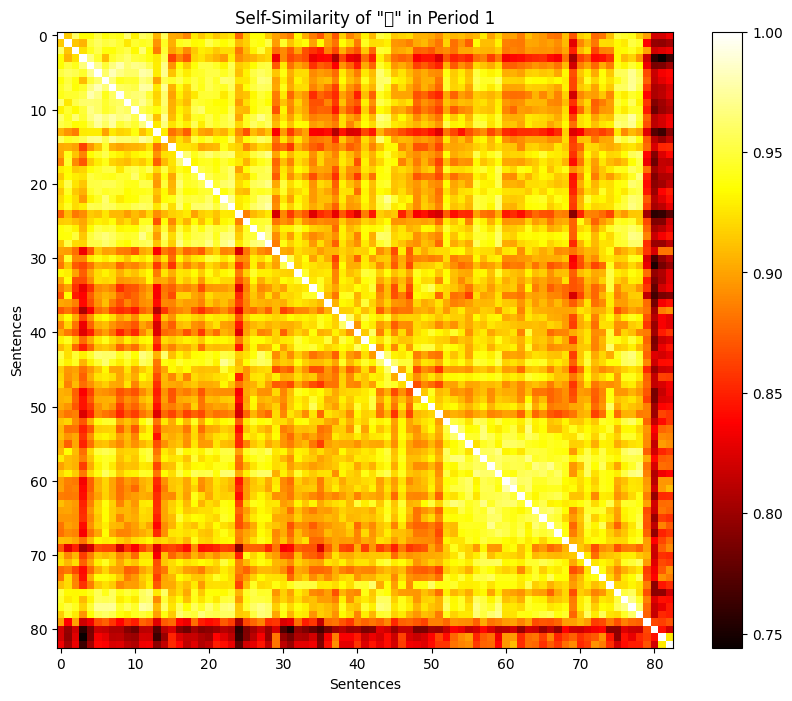

In [26]:
plot_self_similarity(self_similarity1, 'Self-Similarity of "仁" in Period 1')

### Self-Similarity of "仁" in Period 2

/Users/osakiyutaka/.pyenv/versions/3.10.4/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20161 (\N{CJK UNIFIED IDEOGRAPH-4EC1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


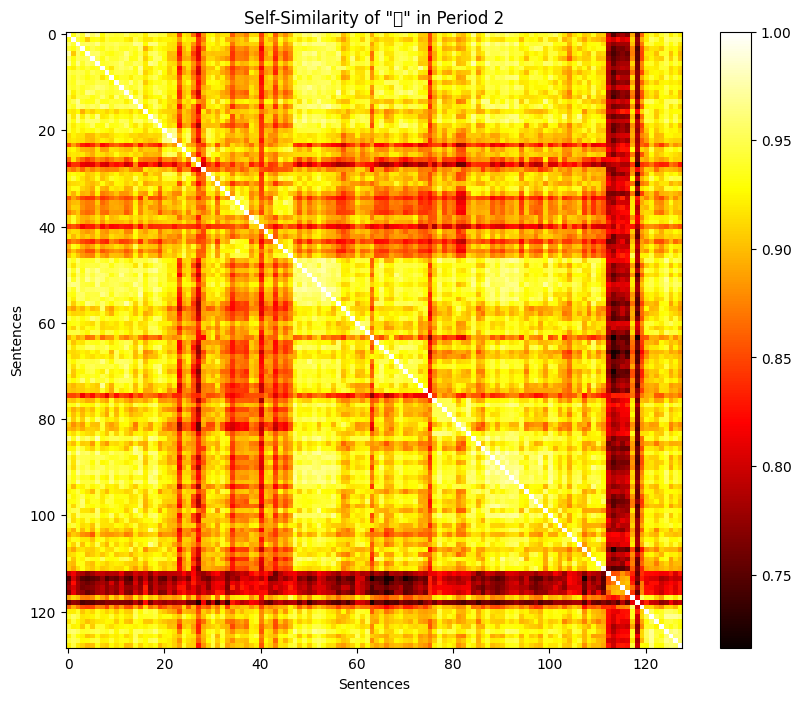

In [24]:
plot_self_similarity(self_similarity2, 'Self-Similarity of "仁" in Period 2')

### Self-Similarity of "仁" in Period 3

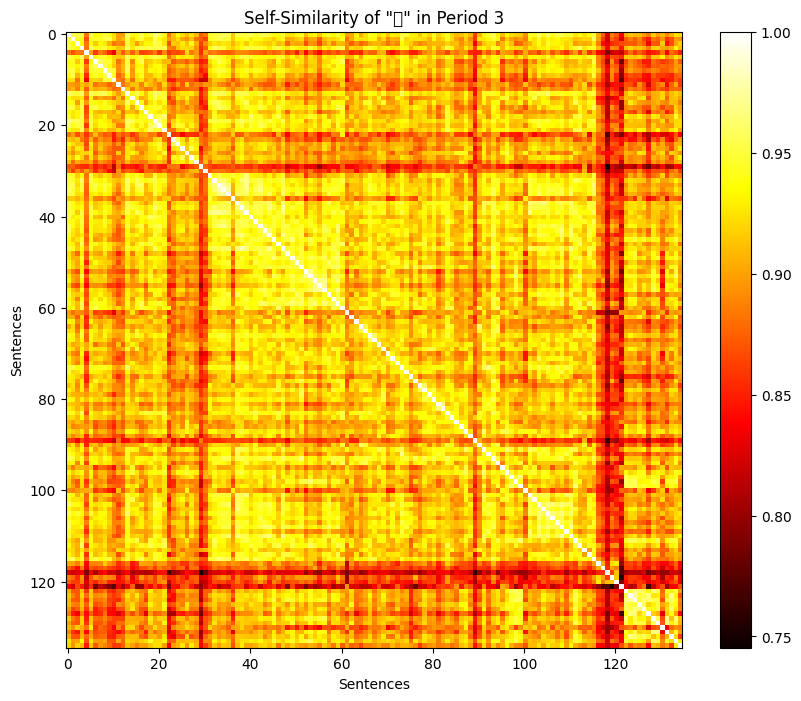

In [25]:
plot_self_similarity(self_similarity3, 'Self-Similarity of "仁" in Period 3')

### Seld-Similarity of 仁 in three periods

/Users/osakiyutaka/.pyenv/versions/3.10.4/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20161 (\N{CJK UNIFIED IDEOGRAPH-4EC1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


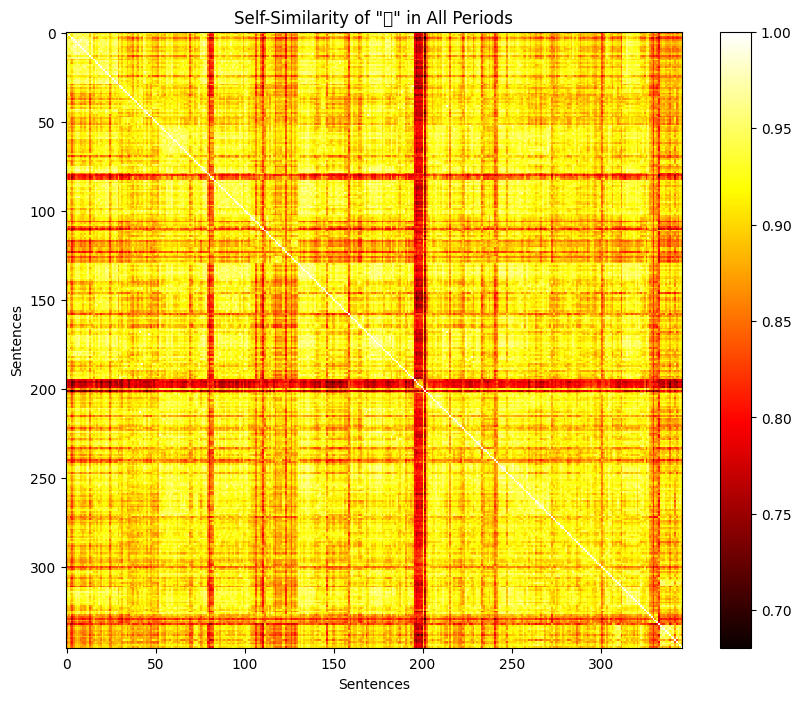

In [27]:
# Compute and plot self-similarity for all sentences containing "仁"
all_embeddings = embeddings1 + embeddings2 + embeddings3
self_similarity_all = compute_self_similarity(all_embeddings)
plot_self_similarity(self_similarity_all, 'Self-Similarity of "仁" in All Periods')

## Method 2

In [33]:
# Function to compute word embeddings
def get_embedding(text):
    """
    This function takes a text string as input and returns the BERT embedding of the text.
    The text is tokenized and input to a pretrained BERT model. The output embeddings from the model are averaged to get a single vector representation for the text.
    Args:
        text (str): The input text string.
    Returns:
        numpy.ndarray: The averaged BERT embedding of the input text.
    """
    inputs = tokenizer_embed(text, return_tensors="pt", truncation=True, padding=True, max_length=MAX_LENGTH)
    with torch.no_grad():
        outputs = model_embed(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Function to compute average word vectors for keywords
def compute_average_embeddings(df, keywords):
    """
    This function computes the average BERT embeddings for each keyword in the input list.
    The function iterates over each text in the 'segmented' column of the input DataFrame, and for each keyword that appears in the text, it computes the BERT embedding of the text and adds it to a list of embeddings for that keyword.
    Finally, it computes the average embedding for each keyword by averaging the list of embeddings for that keyword.
    Args:
        df (pandas.DataFrame): The input DataFrame.
        keywords (list of str): The list of keywords.
    Returns:
        dict of str to numpy.ndarray: A dictionary mapping each keyword to its average BERT embedding.
    """
    embeddings = {keyword: [] for keyword in keywords}
    for text in df['segmented']:
        sentences = text.split("。")
        for sentence in sentences:
            for keyword in keywords:
                if keyword in sentence:
                    embedding = get_embedding(sentence)
                    embeddings[keyword].append(embedding)

    avg_embeddings = {keyword: np.mean(embeddings[keyword], axis=0) for keyword in keywords if embeddings[keyword]}
    return avg_embeddings

# Calculate the similarity between "仁" and keywords
def calculate_similarities(ren_embedding, avg_embeddings):
    """
    This function calculates the cosine similarity between the BERT embedding of the character "仁" and the average BERT embeddings of a list of keywords.
    The function iterates over each keyword and its average embedding in the input dictionary, computes the cosine similarity between the "仁" embedding and the keyword embedding, and adds the similarity to a dictionary.
    Args:
        ren_embedding (numpy.ndarray): The BERT embedding of the character "仁".
        avg_embeddings (dict of str to numpy.ndarray): A dictionary mapping each keyword to its average BERT embedding.
    Returns:
        dict of str to float: A dictionary mapping each keyword to its cosine similarity with the "仁" embedding.
    """
    similarities = {}
    for keyword, embedding in avg_embeddings.items():
        similarity = cosine_similarity([ren_embedding], [embedding])[0][0]
        similarities[keyword] = similarity
    return similarities
def plot_similarity(keywords, keywords_translation, similarities1, similarities2, similarities3):
    """
    This function plots a bar chart of the cosine similarities between the "仁" embedding and the average keyword embeddings for each period.
    Args:
        keywords (list of str): The list of keywords.
        keywords_translation (list of str): The list of English translations for the keywords.
        similarities1 (dict of str to float): A dictionary mapping each keyword to its cosine similarity with the "仁" embedding for the first period.
        similarities2 (dict of str to float): A dictionary mapping each keyword to its cosine similarity with the "仁" embedding for the second period.
        similarities3 (dict of str to float): A dictionary mapping each keyword to its cosine similarity with the "仁" embedding for the third period.
    """
    # Prepare data for plotting
    data = {
        'keyword': keywords_translation,
        '480BCE-202BCE': [similarities1.get(keyword, 0) for keyword in keywords],
        '202BCE-25CE': [similarities2.get(keyword, 0) for keyword in keywords],
        '25CE-300CE': [similarities3.get(keyword, 0) for keyword in keywords]
    }

    df = pd.DataFrame(data)
    df = df.melt(id_vars='keyword', var_name='period', value_name='similarity')

    # Print DataFrame to check keyword order
    print(df)

    # Plot bar chart
    plt.figure(figsize=(14, 8))
    sns.barplot(data=df, x='keyword', y='similarity', hue='period', palette='muted')
    plt.xlabel('Keywords')
    plt.ylabel('Cosine similarity between "Benevolence" and keywords')
    plt.ylim(0.58, 0.63)
    plt.title('Cosine similarity of "Benevolence" and keywords across different periods')
    plt.legend(title='Period', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

### Human Ethics and Relationship

贤 (virtuous), 礼 (rites), 中 (moderation), 和 (harmony), 小 (small), 经 (classic), 常 (constant), 伦 (ethics), 孝 (filial piety), 正 (righteous), 圣 (sage), 尊 (respect), 亲 (familial)


In [34]:
# List of keywords
keywords = ["贤", "礼", "中", "和", "小", "经", "常", "伦", "孝", "正", "圣", "尊", "亲"]
keywords_translation = ["virtuous", "rites", "moderation", "harmony", "small", "classic", "constant", "ethics", "filial piety", "righteous", "sage", "respect", "familial"]

# Compute the average keyword embeddings for each period
avg_embeddings1 = compute_average_embeddings(data_period1, keywords)
avg_embeddings2 = compute_average_embeddings(data_period2, keywords)
avg_embeddings3 = compute_average_embeddings(data_period3, keywords)

# Get the embedding for "仁"
ren_embedding1 = get_embedding("仁")
ren_embedding2 = get_embedding("仁")
ren_embedding3 = get_embedding("仁")

similarities1 = calculate_similarities(ren_embedding1, avg_embeddings1)
similarities2 = calculate_similarities(ren_embedding2, avg_embeddings2)
similarities3 = calculate_similarities(ren_embedding3, avg_embeddings3)

In [ ]:
plot_similarity(keywords, keywords_translation, similarities1, similarities2, similarities3)

### Political Governance

君 (ruler), 臣 (minister), 天 (heaven), 命 (fate), 道 (way), 德 (virtue), 父 (father), 子 (son), 妻 (wife), 家 (family), 国 (country), 政 (governance), 治 (politics), 法 (law)

In [ ]:
# List of keywords
keywords = ["君", "臣", "天", "命", "道", "德", "父", "子", "妻", "家", "国", "政", "治", "法"]
keywords_translation = ["ruler", "minister", "heaven", "fate", "way", "virtue", "father", "son", "wife", "family", "country", "governance", "politics", "law"]

# Compute the average keyword embeddings for each period
avg_embeddings1 = compute_average_embeddings(data_period1, keywords)
avg_embeddings2 = compute_average_embeddings(data_period2, keywords)
avg_embeddings3 = compute_average_embeddings(data_period3, keywords)

# Get the embedding for "仁"
ren_embedding1 = get_embedding("仁")
ren_embedding2 = get_embedding("仁")
ren_embedding3 = get_embedding("仁")

similarities1 = calculate_similarities(ren_embedding1, avg_embeddings1)
similarities2 = calculate_similarities(ren_embedding2, avg_embeddings2)
similarities3 = calculate_similarities(ren_embedding3, avg_embeddings3)

In [ ]:
plot_similarity(keywords, keywords_translation, similarities1, similarities2, similarities3)

### Human Life

善 (goodness), 恶 (evil), 义 (righteousness), 知 (knowledge), 信 (trust), 性 (nature), 欲 (desire), 修 (cultivate), 齐 (regulate), 贵 (noble), 贱 (humble), 人 (human), 生 (life)

In [ ]:
# List of keywords
keywords = ["善", "恶", "义", "知", "信", "性", "欲", "修", "齐", "贵", "贱", "人", "生"]
keywords_translation = ["goodness", "evil", "righteousness", "knowledge", "trust", "nature", "desire", "cultivate", "regulate", "noble", "humble", "human", "life"]

# Compute the average keyword embeddings for each period
avg_embeddings1 = compute_average_embeddings(data_period1, keywords)
avg_embeddings2 = compute_average_embeddings(data_period2, keywords)
avg_embeddings3 = compute_average_embeddings(data_period3, keywords)

# Get the embedding for "仁"
ren_embedding1 = get_embedding("仁")
ren_embedding2 = get_embedding("仁")
ren_embedding3 = get_embedding("仁")

similarities1 = calculate_similarities(ren_embedding1, avg_embeddings1)
similarities2 = calculate_similarities(ren_embedding2, avg_embeddings2)
similarities3 = calculate_similarities(ren_embedding3, avg_embeddings3)

In [ ]:
plot_similarity(keywords, keywords_translation, similarities1, similarities2, similarities3)